<!-- <div dir="rtl"> -->
<center>
<h2>Machine Learning course project</h2>
<span style="color:red"><h3>Sentiment Analysis</h3></span>
<h3>Mohammad Abolnejadian - 98103867</h3>
</center>
<!-- </div> -->


### You can access this project via this colab link: https://colab.research.google.com/drive/1IAYrGgC85AOlhRr3EmdL5T1ji6uZSsND?usp=sharing

**For more info on this project, please read the doc (in persian) that comes with it.**

First, we import the packages that we need during the course of this project. Run the following cell to import them.

In [630]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

import nltk
from nltk import word_tokenize, pos_tag
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer

from imblearn.under_sampling import RandomUnderSampler

from gensim.models import Word2Vec

from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay, confusion_matrix, classification_report
# from keras.utils.np_utils import to_categorical
#######MODELS#######
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from keras.models import Sequential
from keras.layers import Dense

In [631]:
tqdm.pandas()
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /Users/mhd/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/mhd/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/mhd/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /Users/mhd/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# Data Prepration

In this part, first we import our data into a pandas dataframe, and then we preprocess it with methods like lowercasing, removing stopwords, lemmatization, etc. to make it ready for the word embedding which we will do in the next part.

Run the following cell to import the dataset into a pandas dataframe.

In [632]:
# df = pd.read_csv('/kaggle/input/ml-project-sentiment-analysis/data-train.csv')
target_names = ['negative', 'semi-negative', 'neutral', 'semi-positive', 'positive']
df = pd.read_csv('data-train.csv')
df.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


As it can be seen, the data which is presented has two importand values; `PhraseId` and `SentenceId`. We will create another dataframe to keep only the unique sentence and then run sentiment analysis and some data exploration on them too.

Let's first find the pattern and see how we can find the unique sentences.

In [633]:
df_1 = df.loc[df['SentenceId'] == 1]
print(df_1.iloc[:5])
df_2 = df.loc[df['SentenceId'] == 2]
print(df_2.iloc[:5])

   PhraseId  SentenceId                                             Phrase  \
0         1           1  A series of escapades demonstrating the adage ...   
1         2           1  A series of escapades demonstrating the adage ...   
2         3           1                                           A series   
3         4           1                                                  A   
4         5           1                                             series   

   Sentiment  
0          1  
1          2  
2          2  
3          2  
4          2  
    PhraseId  SentenceId                                             Phrase  \
63        64           2  This quiet , introspective and entertaining in...   
64        65           2  This quiet , introspective and entertaining in...   
65        66           2                                               This   
66        67           2  quiet , introspective and entertaining indepen...   
67        68           2             quiet , i

As it can be seen, the first phrase of each `SentenceId` is the whole sentence for that group of phrases. So let's extract the unique sentences using the knowledge that we gained and store these sentences in anohter dataframe called `df_sentences`

In [634]:
grouped_df = df.groupby("SentenceId")
df_sentences = grouped_df.first()
df_sentences.head()

,PhraseId,Phrase,Sentiment
SentenceId,,,
1,1,A series of escapades demonstrating the adage ...,1
2,64,"This quiet , introspective and entertaining in...",4
3,82,"Even fans of Ismail Merchant 's work , I suspe...",1
4,117,A positively thrilling combination of ethnogra...,3
5,157,Aggressive self-glorification and a manipulati...,1


# Data Exploration

First, we perform a quick EDA on the dataset.

In [635]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 155048 entries, 0 to 155047
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   PhraseId    155048 non-null  int64 
 1   SentenceId  155048 non-null  int64 
 2   Phrase      155048 non-null  object
 3   Sentiment   155048 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 4.7+ MB


Let's compare the number of sentences to the number of phrases

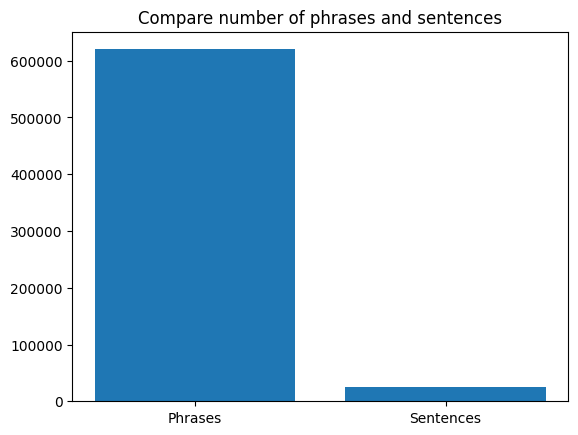

In [636]:
plt.bar(["Phrases", "Sentences"], [df.size, df_sentences.size])
plt.title("Compare number of phrases and sentences")
plt.show()

Now, let's see how many phrases we have for each sentiment.

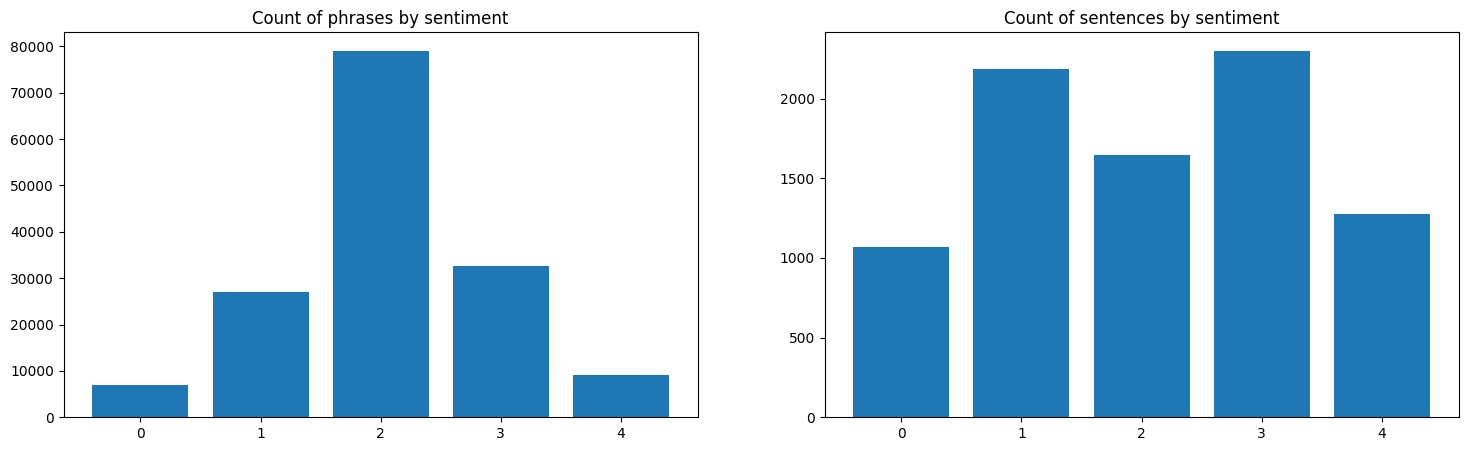

In [499]:
fig, axes = plt.subplots(1, 2, figsize=(18, 5))
df_counts = df['Sentiment'].value_counts().sort_index()
df_sentences_counts = df_sentences['Sentiment'].value_counts().sort_index()

# Plot the first subplot
axes[0].bar(df_counts.index, df_counts.values, label="df1")
axes[0].set_title("Count of phrases by sentiment")

# Plot the second subplot
axes[1].bar(df_sentences_counts.index, df_sentences_counts.values, label="df2")
axes[1].set_title("Count of sentences by sentiment")

# Show the figure
plt.show()

# Data Vectorization (Extracting features)

## 0. Data Split 

In [637]:
# X_train, X_test, y_train, y_test = train_test_split(df, test_size=0.2, random_state=1)
# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=1)
df_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_validation = train_test_split(df_train, test_size=0.1, random_state=1)
df_train.size, df_test.size, df_validation.size
# X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

(446536, 124040, 49616)

Turning data into `x` and `y` arrays.

In [638]:
X_train = np.array(df_train['Phrase'])
y_train = np.array(df_train['Sentiment'])
X_test = np.array(df_test['Phrase'])
y_test = np.array(df_test['Sentiment'])
X_val = np.array(df_validation['Phrase'])
y_val = np.array(df_validation['Sentiment'])
X_train.shape, y_train.shape, X_test.shape, y_test.shape, X_val.shape, y_val.shape

((111634,), (111634,), (31010,), (31010,), (12404,), (12404,))

## 1. Data Preprocessing

Lowercasing all the phrases

In [502]:
df['Phrase']=df['Phrase'].str.lower()
df.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,a series of escapades demonstrating the adage ...,1
1,2,1,a series of escapades demonstrating the adage ...,2
2,3,1,a series,2
3,4,1,a,2
4,5,1,series,2


Remove extra white spaces

In [503]:
def remove_whitespace(text):
    return  " ".join(text.split())

df['Phrase']=df['Phrase'].progress_apply(remove_whitespace)
df.head()

100%|██████████| 155048/155048 [00:00<00:00, 1268834.82it/s]


,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,a series of escapades demonstrating the adage ...,1
1,2,1,a series of escapades demonstrating the adage ...,2
2,3,1,a series,2
3,4,1,a,2
4,5,1,series,2


Word toknization:
In this part, we tokenize each phrase by words.

In [504]:
df['Phrase']=df['Phrase'].progress_apply(lambda x: word_tokenize(x))
df.head()

100%|██████████| 155048/155048 [00:05<00:00, 26904.81it/s]


,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,"[a, series, of, escapades, demonstrating, the,...",1
1,2,1,"[a, series, of, escapades, demonstrating, the,...",2
2,3,1,"[a, series]",2
3,4,1,[a],2
4,5,1,[series],2


Removing stopwords

In [505]:
en_stopwords = stopwords.words('english')
def remove_stopwords(tokens):
    result = []
    for word in tokens:
        if word not in en_stopwords:
            result.append(word)
    return result
df['Phrase'] = df['Phrase'].progress_apply(remove_stopwords)
df.head()

100%|██████████| 155048/155048 [00:01<00:00, 152556.43it/s]


,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,"[series, escapades, demonstrating, adage, good...",1
1,2,1,"[series, escapades, demonstrating, adage, good...",2
2,3,1,[series],2
3,4,1,[],2
4,5,1,[series],2


Removing punctuations

In [506]:
def remove_punctuation(text):
    tokenizer = RegexpTokenizer(r"\w+")
    lst=tokenizer.tokenize(' '.join(text))
    return lst
df['Phrase']= df['Phrase'].progress_apply(lambda x:remove_punctuation(x))
df.head()

100%|██████████| 155048/155048 [00:00<00:00, 490272.07it/s]


,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,"[series, escapades, demonstrating, adage, good...",1
1,2,1,"[series, escapades, demonstrating, adage, good...",2
2,3,1,[series],2
3,4,1,[],2
4,5,1,[series],2


Word lemmatization

In [507]:
def lemmatization(text):
    result=[]
    wordnet = WordNetLemmatizer()
    for token,tag in pos_tag(text):
        pos=tag[0].lower()
        if pos not in ['a', 'r', 'n', 'v']:
            pos='n' #for better lammatization
        result.append(wordnet.lemmatize(token,pos))
    
    return result

df['Phrase']=df['Phrase'].progress_apply(lemmatization)
df.head()

100%|██████████| 155048/155048 [00:22<00:00, 6914.44it/s]


,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,"[series, escapades, demonstrating, adage, good...",1
1,2,1,"[series, escapades, demonstrating, adage, good...",2
2,3,1,[series],2
3,4,1,[],2
4,5,1,[series],2


Drop empty phrases

In [508]:
df["Phrase_word_len"] = df["Phrase"].apply(len)
df = df[df["Phrase_word_len"] > 0]
df = df.drop(columns=["Phrase_word_len"], axis=1)
df.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,"[series, escapades, demonstrating, adage, good...",1
1,2,1,"[series, escapades, demonstrating, adage, good...",2
2,3,1,[series],2
4,5,1,[series],2
5,6,1,"[escapade, demonstrate, adage, good, goose]",2


Now that we demonstrated how all the preprocessings work on our dataset, we can perform our desired task

### All of the preprocessing gathered together

We gather all the preprocessing methods into a pipeline, so we can leverage this method in future.

In [715]:
def preprocess_texts_pipeline(texts, labels):
    results_x = []
    results_y = []
    for i, text in enumerate(tqdm(texts)):
        text = text.lower() #lower casing
        text = remove_whitespace(text) #remove extra whitespaces
        tokens = word_tokenize(text) #tokenization
        # tokens = remove_stopwords(tokens) #remove stopwords
        tokens = remove_punctuation(tokens) #remove punctuation
        tokens = lemmatization(tokens) #lemmatization
        #remove tokens which has length less than 2
        tokens = [token for token in tokens if len(token) > 1]
        if len(tokens) > 0:
            results_x.append(tokens)
            results_y.append(labels[i])
    return np.array(results_x, dtype=object), np.array(results_y, dtype='int')

### Fixing class imbalance in training data

We solve the problem of having imbalanced number of samples in each class (here being sentiments), with the `Under Sampling` method.

First, let's see how many samples do we have in each class.

In [640]:
class_count = df_train.groupby(['Sentiment']).count()
class_count = class_count.drop(['PhraseId', 'SentenceId'], axis=1)
total_number_of_phrases = class_count['Phrase'].sum()
print("Total number of phrases in training data: " + str(total_number_of_phrases))
class_count

Total number of phrases in training data: 111634


,Phrase
Sentiment,
0,5039
1,19563
2,56983
3,23451
4,6598


Now, we under sample the training dataset.

In [641]:
rus = RandomUnderSampler(random_state=42, replacement=False)# fit predictor and target variable
X_train_balanced, y_train_balanced = rus.fit_resample(X_train.reshape(-1, 1), y_train.reshape(-1, 1))
X_train_balanced, y_train_balanced = X_train_balanced.ravel(), y_train_balanced.ravel()
df_train_balanced = pd.DataFrame({
  "Phrase": X_train_balanced,
  "Sentiment": y_train_balanced  
})
class_count_balanced = df_train_balanced.groupby(['Sentiment']).count()
class_count_balanced

,Phrase
Sentiment,
0,5039
1,5039
2,5039
3,5039
4,5039


## Getting word embeddings

First, let's preprocess our balanced training dataset

In [642]:
X_train_balanced, y_train_balanced = preprocess_texts_pipeline(X_train_balanced, y_train_balanced)
X_val, y_val = preprocess_texts_pipeline(X_val, y_val)
X_test, y_test = preprocess_texts_pipeline(X_test, y_test)
X_train_balanced[:5]

100%|██████████| 31010/31010 [00:06<00:00, 4884.59it/s]


array([list(['scenic', 'appeal', 'cesspool']),
       list(['sweep', 'away', 'sink']), list(['ungainly', 'movie']),
       list(['terrible', 'film']),
       list(['disappoint', 'woody', 'allen', 'movie', 'ever'])],
      dtype=object)

### Method 1. Using premitive method (TF-IDF)

First, let's get the embeddings of each word using tf-idf.

In [643]:
tf_idf_vectorizer = TfidfVectorizer()
X_train_tf_idf = tf_idf_vectorizer.fit_transform([" ".join(x) for x in X_train_balanced])
X_train_tf_idf.shape

(25112, 11181)

In [644]:
X_test_tf_idf = tf_idf_vectorizer.transform([" ".join(x) for x in X_test])
X_test_tf_idf.shape

(30751, 11181)

### Method 2. Using a new method (Word2Vec)

Now using the new methods, we leverage the `gensim`'s Word2Vec class to get the word embeddings for our training dataset.</br>
We will use two methods two get the word embeddings:
1. CBOW (Continous Bag of Words)
2. Skip gram
each of these method are explained throughly in the project's documentation.

#### 1. CBOW

In [645]:
vector_size = 128
cbow_model = Word2Vec(X_train_balanced, vector_size=vector_size, window=5, min_count=1, workers=4, sg = 0)

#### 1. Skip gram

In [646]:
skipgram_model = Word2Vec(X_train_balanced, vector_size=vector_size, window=5, min_count=1, workers=4, sg = 1)

In [647]:
print("Vocabulary of the CBOW model:")
for word, index in cbow_model.wv.key_to_index.items():
    print(f"{word}: {index}")
    if index > 10:
        break
print("...")
print(f"Length of vocabulary: {len(cbow_model.wv)}")

Vocabulary of the CBOW model:
movie: 0
film: 1
make: 2
one: 3
like: 4
character: 5
story: 6
time: 7
good: 8
well: 9
comedy: 10
bad: 11
...
Length of vocabulary: 11181


Let's visualize the word embeddings of vocabulary using PCA (we only visualize the cbow model)

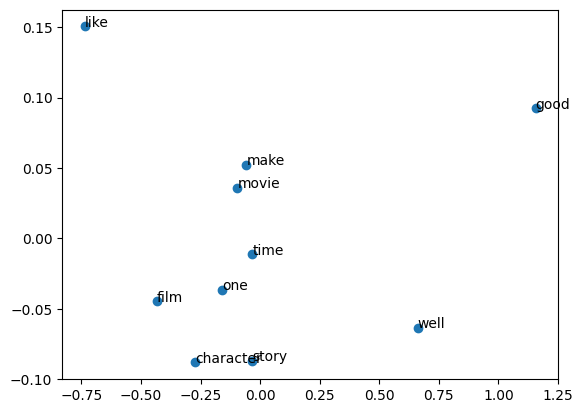

In [648]:
pca = PCA(n_components=2)
ten_first_words = list(cbow_model.wv.key_to_index.keys())[:10]
X_ten_first_words = [cbow_model.wv.get_vector(x) for x in ten_first_words]
result = pca.fit_transform(X_ten_first_words)
plt.scatter(result[:, 0], result[:, 1])
for i, word in enumerate(ten_first_words):
 plt.annotate(word, xy=(result[i, 0], result[i, 1]))
plt.show()

As it can be seen, words with similar meanings are closer to each other on the plot. More details can be seen on the project's report.

### Vectorize each phrase

In [707]:
def transform_word2vec(model, texts, labels, vector_size = 128):
    # vectors = np.zeros((len(texts), vector_size))
    vectors = []
    labels_refined = []
    for i, text in enumerate(texts):
        # initial_vector = [model.wv.get_vector(token) for token in text]
        initial_vector = [model.wv.get_vector(token) for token in text if token in model.wv.key_to_index.keys()]
        if len(initial_vector) > 0: 
            # vectors[i, :] = np.mean(initial_vector, axis=0)
            vectors.append(np.mean(initial_vector, axis=0))
            labels_refined.append(labels[i])
    # return vectors
    return np.array(vectors), np.array(labels_refined)

In [650]:
X_train_balanced_cbow, y_train_balanced_cbow = transform_word2vec(cbow_model, X_train_balanced, y_train_balanced,vector_size)
X_train_balanced_skip_gram, y_train_balanced_skip_gram = transform_word2vec(skipgram_model, X_train_balanced, y_train_balanced, vector_size)
X_train_balanced_cbow.shape, X_train_balanced_skip_gram.shape

((25112, 128), (25112, 128))

In [651]:
X_val_skip_gram, y_val_skip_gram = transform_word2vec(skipgram_model, X_val, y_val)
X_test_skip_gram, y_test_skip_gram = transform_word2vec(skipgram_model, X_test, y_test)
X_val_skip_gram.shape

(12071, 128)

# Training Models

In this part, we will train several models.

### Hyperparameter tuning

First, we implement a way so we can tune hyperparameters in our models using the validation set

In [596]:
def model_hyperparameter_tuning_with_validation_set(model, params, x_train, y_train, x_val, y_val):
    best_score = 0
    best_params = dict()
    best_model = None
    for param in tqdm(params):
      model_tuning = model(**param)
      model_tuning.fit(x_train, y_train)
      score = model_tuning.score(x_val, y_val)
      if score > best_score:
        best_score = score
        best_params = param
        best_model = model_tuning
    return best_model

### Confusion matrix plotting

We also code a function to draw the plot for confusion matrix so we don't have to repeat ourself everytime

In [597]:
def plot_confusion_matrix(cf_matrix):
    disp = ConfusionMatrixDisplay(cf_matrix, display_labels=target_names, )
    fig, ax = plt.subplots(figsize=(10, 10))
    disp.plot(ax=ax, cmap=plt.cm.Blues, xticks_rotation='vertical')
    plt.show()

### Running evaluations

The following is the code that ouputs 3 things to evaluate the sentiment analysis:
1. Classification report
2. Accuracy score
3. Confusion matrix

In [598]:
def analysis_evaluation(y_test, prediction, target_names):
    print(classification_report(y_test, prediction, target_names=target_names))
    print(f"Accuracy: {accuracy_score(y_test, prediction)}")
    cf_matrix_lr = confusion_matrix(y_test, prediction, normalize='true')
    plot_confusion_matrix(cf_matrix_lr)

## 1. Logistic Regression

In [573]:
logistic_regression_params = {'tol': np.logspace(-4, -2, 3), 'C': np.logspace(-1, 3, 5)}
param_grid_lr = ParameterGrid(logistic_regression_params)
lr_model = LogisticRegression
lr_model = model_hyperparameter_tuning_with_validation_set(lr_model, param_grid_lr, X_train_balanced_skip_gram, y_train_balanced_skip_gram, X_val_skip_gram, y_val_skip_gram) 

100%|██████████| 15/15 [00:15<00:00,  1.07s/it]


               precision    recall  f1-score   support

     negative       0.08      0.31      0.13      1429
semi-negative       0.24      0.13      0.17      5347
      neutral       0.61      0.36      0.45     15038
semi-positive       0.28      0.21      0.24      6534
     positive       0.12      0.53      0.19      1834

     accuracy                           0.29     30182
    macro avg       0.27      0.31      0.24     30182
 weighted avg       0.42      0.29      0.32     30182

Accuracy: 0.29414883042873236


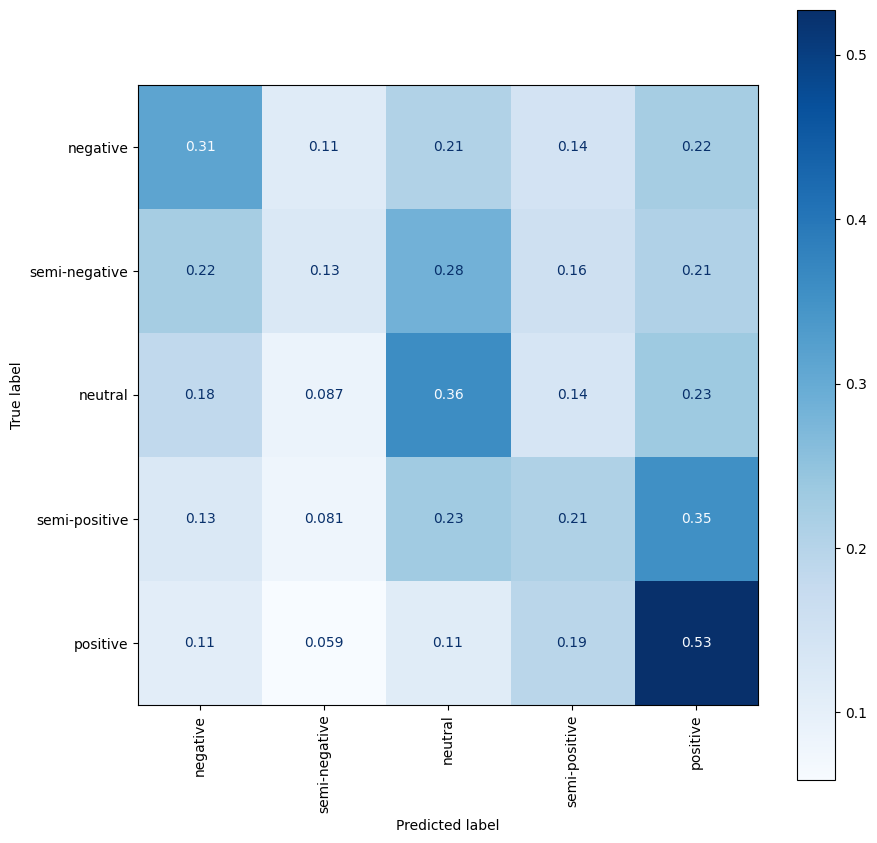

In [652]:
lr_predictions = lr_model.predict(X_test_skip_gram)
analysis_evaluation(y_test_skip_gram, lr_predictions, target_names)

## 2. Gaussian Naive Bayes

In [664]:
gnb_params = {'var_smoothing': np.logspace(-9, -5, 5)}
param_grid_gnb = ParameterGrid(gnb_params)
gnb_model = GaussianNB
gnb_model = model_hyperparameter_tuning_with_validation_set(gnb_model, param_grid_gnb, X_train_balanced_skip_gram, y_train_balanced_skip_gram, X_val_skip_gram, y_val_skip_gram) 

100%|██████████| 5/5 [00:00<00:00, 28.30it/s]


               precision    recall  f1-score   support

     negative       0.07      0.29      0.12      1429
semi-negative       0.20      0.20      0.20      5347
      neutral       0.67      0.25      0.37     15038
semi-positive       0.27      0.02      0.03      6534
     positive       0.09      0.62      0.15      1834

     accuracy                           0.22     30182
    macro avg       0.26      0.27      0.17     30182
 weighted avg       0.43      0.22      0.24     30182

Accuracy: 0.21526075144125636


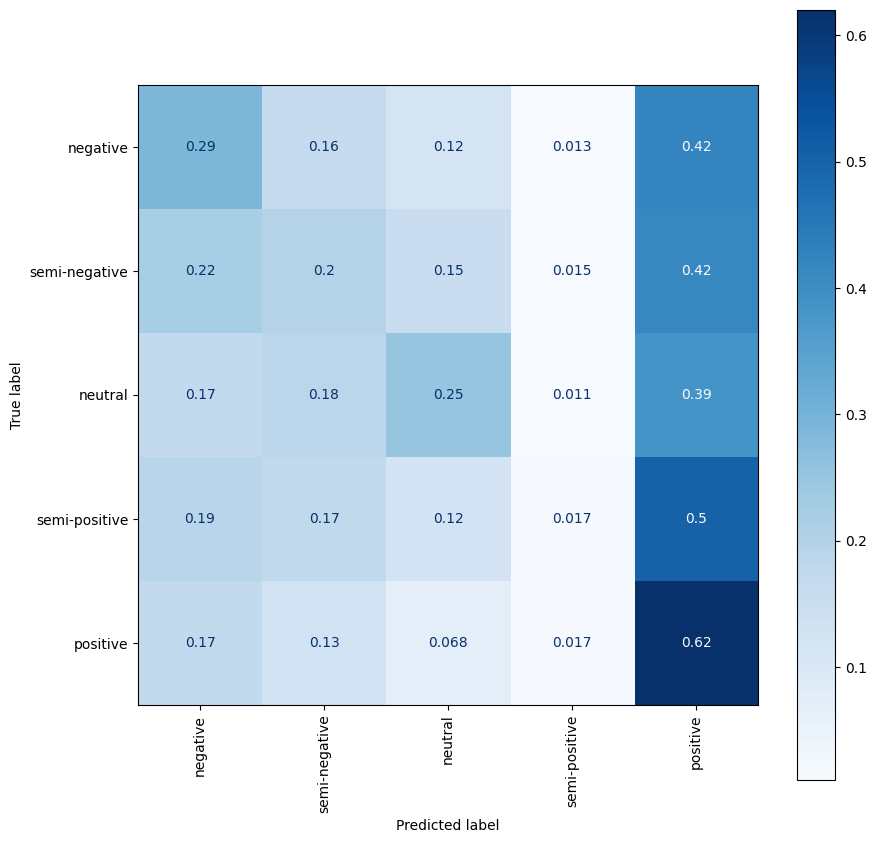

In [665]:
gnb_predictions = gnb_model.predict(X_test_skip_gram)
analysis_evaluation(y_test_skip_gram, gnb_predictions, target_names)

## 3. Random Forest

In [601]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 2)]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 50, num = 2)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5]
# Method of selecting samples for training each tree
bootstrap = [True, False]
rf_params = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'bootstrap': bootstrap}
param_grid_rf = ParameterGrid(rf_params)
rf_model = RandomForestClassifier
rf_model = model_hyperparameter_tuning_with_validation_set(rf_model, param_grid_rf, X_train_balanced_skip_gram, y_train_balanced_skip_gram, X_val_skip_gram, y_val_skip_gram)

100%|██████████| 24/24 [54:02<00:00, 135.09s/it]


               precision    recall  f1-score   support

     negative       0.20      0.46      0.28      1429
semi-negative       0.30      0.29      0.30      5347
      neutral       0.70      0.48      0.57     15038
semi-positive       0.33      0.32      0.33      6534
     positive       0.19      0.52      0.28      1834

     accuracy                           0.41     30182
    macro avg       0.34      0.41      0.35     30182
 weighted avg       0.49      0.41      0.44     30182

Accuracy: 0.41229872109204163


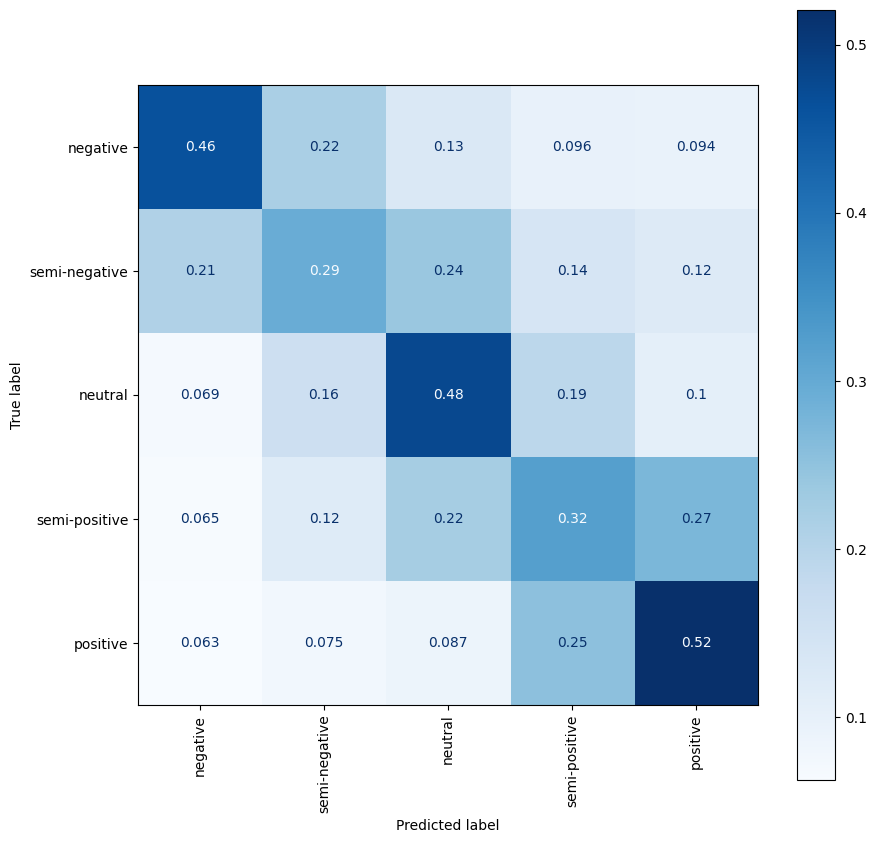

In [654]:
rf_predictions = rf_model.predict(X_test_skip_gram)
analysis_evaluation(y_test_skip_gram, rf_predictions, target_names)

## 4. Adaboost

In [582]:
adaboost_params = {
    'n_estimators': [50, 100, 150, 200],
    'learning_rate': np.logspace(-1, 1, 3),
}
param_grid_adaboost = ParameterGrid(adaboost_params)
adaboost_model = AdaBoostClassifier
adaboost_model = model_hyperparameter_tuning_with_validation_set(adaboost_model, param_grid_adaboost, X_train_balanced_skip_gram, y_train_balanced_skip_gram, X_val_skip_gram, y_val_skip_gram)

100%|██████████| 12/12 [08:02<00:00, 40.22s/it]


               precision    recall  f1-score   support

     negative       0.16      0.00      0.01      1429
semi-negative       0.00      0.00      0.00      5347
      neutral       0.50      1.00      0.66     15038
semi-positive       0.00      0.00      0.00      6534
     positive       0.32      0.00      0.01      1834

     accuracy                           0.50     30182
    macro avg       0.20      0.20      0.14     30182
 weighted avg       0.28      0.50      0.33     30182

Accuracy: 0.49778013385461534


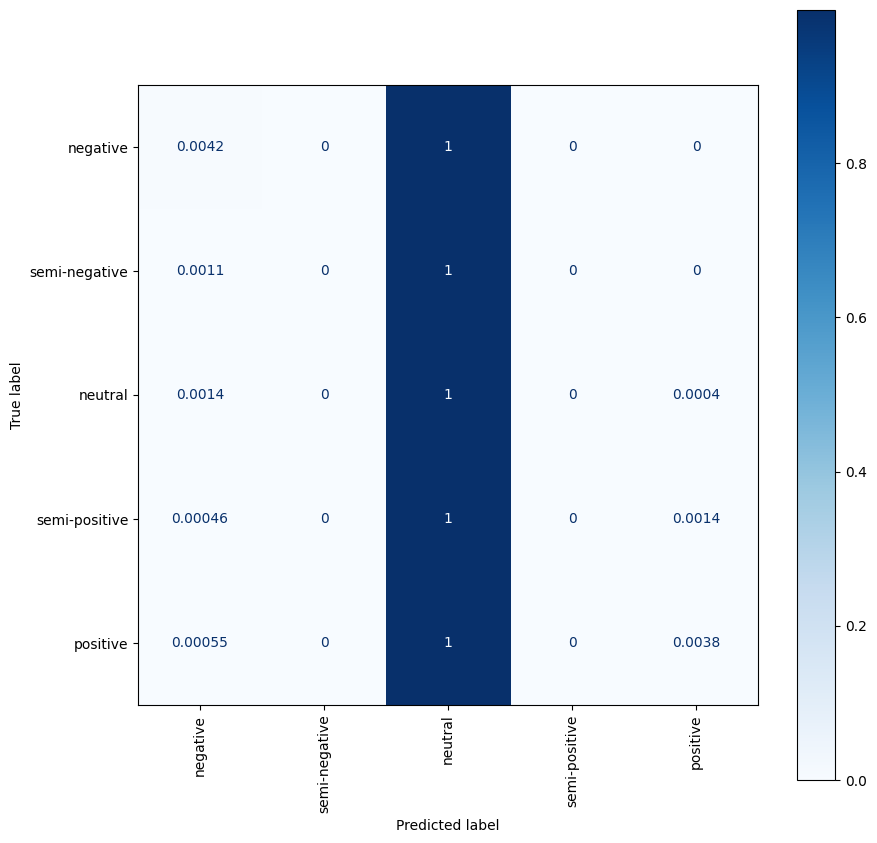

In [655]:
adaboost_predictions = adaboost_model.predict(X_test_skip_gram)
analysis_evaluation(y_test_skip_gram, adaboost_predictions, target_names)

## 5. SVM

In [590]:
C_parameter = np.logspace(-1, 1, 3)
gamma_parameter = [0.01, 0.01, 'scale']
tolerance_parameter = np.logspace(-3, -2, 2)
svc_parameters = {'C':C_parameter,
                     'gamma': gamma_parameter,
                     'tol': tolerance_parameter}
param_grid_svc = ParameterGrid(svc_parameters)
svc_model = SVC
svc_model = model_hyperparameter_tuning_with_validation_set(svc_model, param_grid_svc, X_train_balanced_skip_gram, y_train_balanced_skip_gram, X_val_skip_gram, y_val_skip_gram)

100%|██████████| 18/18 [25:31<00:00, 85.11s/it]


               precision    recall  f1-score   support

     negative       0.11      0.38      0.18      1429
semi-negative       0.23      0.25      0.24      5347
      neutral       0.69      0.35      0.47     15038
semi-positive       0.29      0.24      0.26      6534
     positive       0.15      0.52      0.23      1834

     accuracy                           0.32     30182
    macro avg       0.29      0.35      0.27     30182
 weighted avg       0.46      0.32      0.35     30182

Accuracy: 0.321979988072361


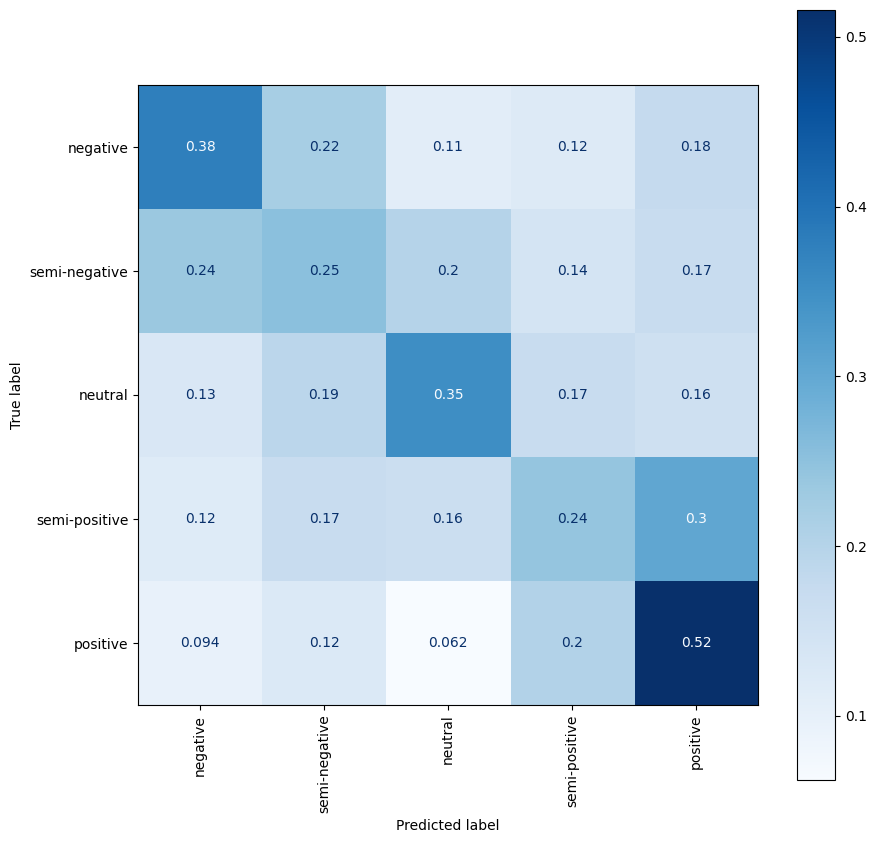

In [656]:
svm_predictions = svc_model.predict(X_test_skip_gram)
analysis_evaluation(y_test_skip_gram, svm_predictions, target_names)

## 6. Neural Network Approaches

### 6.1. Custom NN Model

In [657]:
model = Sequential()
input_dim = X_train_balanced_skip_gram.shape[1]
model.add(Dense(8, input_dim = input_dim, activation = 'relu'))
model.add(Dense(10, activation = 'relu'))
model.add(Dense(10, activation = 'relu'))
model.add(Dense(10, activation = 'relu'))
model.add(Dense(1, activation = 'softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
model.fit(X_train_balanced_skip_gram, y_train_balanced_skip_gram, epochs = 15, batch_size = 5)
scores = model.evaluate(X_test_skip_gram, y_test_skip_gram)
print(scores)

Epoch 1/15
5023/5023 [==============================] - 3s 507us/step - loss: 0.0000e+00 - accuracy: 0.2004
Epoch 2/15
5023/5023 [==============================] - 2s 480us/step - loss: 0.0000e+00 - accuracy: 0.2004
Epoch 3/15
5023/5023 [==============================] - 2s 472us/step - loss: 0.0000e+00 - accuracy: 0.2004
Epoch 4/15
5023/5023 [==============================] - 3s 502us/step - loss: 0.0000e+00 - accuracy: 0.2004
Epoch 5/15
5023/5023 [==============================] - 3s 517us/step - loss: 0.0000e+00 - accuracy: 0.2004
Epoch 6/15
5023/5023 [==============================] - 2s 481us/step - loss: 0.0000e+00 - accuracy: 0.2004
Epoch 7/15
5023/5023 [==============================] - 2s 493us/step - loss: 0.0000e+00 - accuracy: 0.2004
Epoch 8/15
5023/5023 [==============================] - 2s 480us/step - loss: 0.0000e+00 - accuracy: 0.2004
Epoch 9/15
5023/5023 [==============================] - 2s 467us/step - loss: 0.0000e+00 - accuracy: 0.2004
Epoch 10/15
5023/5023 [=====

### 6.2 Sklearn's Multi-layer Perceptron classifier

In [594]:
mlp_parameters = {
    'hidden_layer_sizes': [(10,30,10),(20,)],
    'activation': ['tanh', 'relu'],
    'alpha': [0.0001, 0.05],
}
param_grid_mlp = ParameterGrid(mlp_parameters)
mlp_model = MLPClassifier
mlp_model = model_hyperparameter_tuning_with_validation_set(mlp_model, param_grid_mlp, X_train_balanced_skip_gram, y_train_balanced_skip_gram, X_val_skip_gram, y_val_skip_gram)

100%|██████████| 8/8 [01:10<00:00,  8.77s/it]


               precision    recall  f1-score   support

     negative       0.12      0.29      0.17      1429
semi-negative       0.25      0.20      0.22      5347
      neutral       0.62      0.50      0.55     15038
semi-positive       0.30      0.22      0.26      6534
     positive       0.15      0.46      0.22      1834

     accuracy                           0.37     30182
    macro avg       0.29      0.33      0.29     30182
 weighted avg       0.43      0.37      0.39     30182



Accuracy: 0.37353389437413026


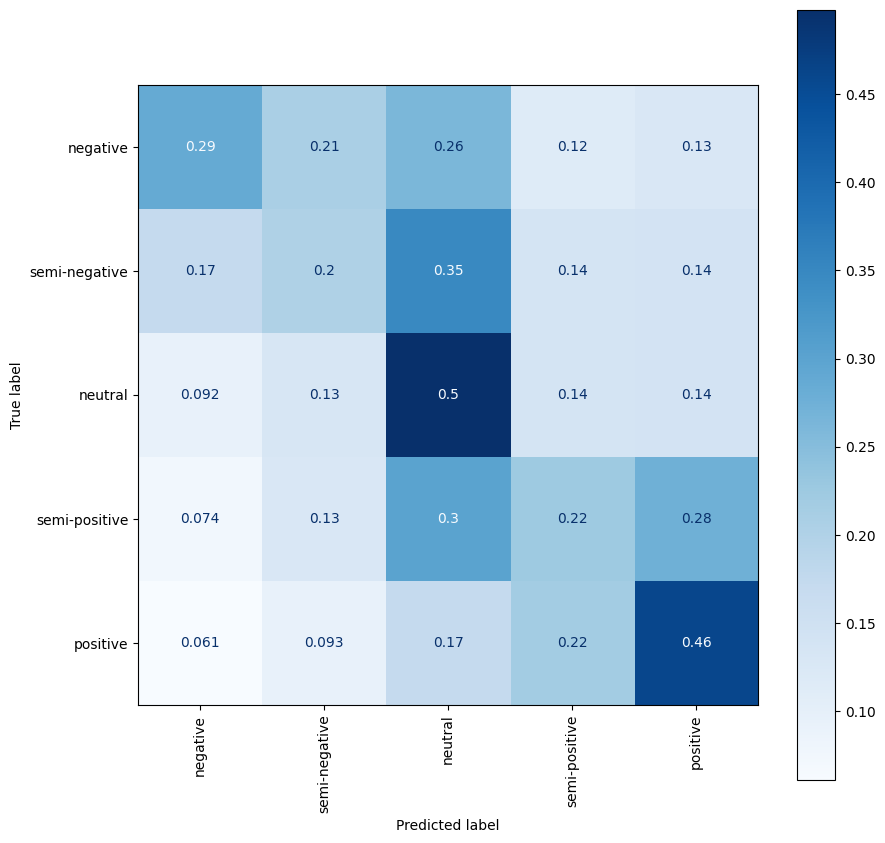

In [605]:
mlp_predictions = mlp_model.predict(X_test_skip_gram)
analysis_evaluation(y_test_skip_gram, mlp_predictions, target_names)

# Comparing results between models

### Comparing word embedding methods

First, we compare the results on a single model (here we use the adaboost model since it performed the best on our dataset), based on different methods of word embedding.

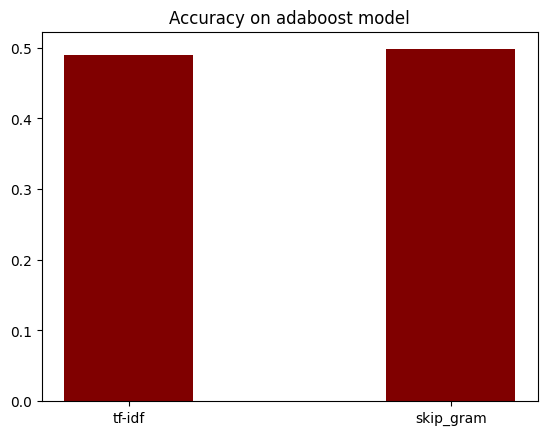

In [658]:
adaboost_model_tf_idf = AdaBoostClassifier().fit(X_train_tf_idf, y_train_balanced)
adaboost_model_tf_predictions = adaboost_model_tf_idf.predict(X_test_tf_idf)
accuracy_tf_idf = accuracy_score(y_test, adaboost_model_tf_predictions)
accuracy_skip_gram = accuracy_score(y_test_skip_gram, adaboost_predictions)
data = {'tf-idf': accuracy_tf_idf, 'skip_gram': accuracy_skip_gram}
plt.bar(data.keys(), data.values(), color ='maroon',
        width = 0.4)
plt.title("Accuracy on adaboost model")
plt.show()

As it can be seen, results are not much different, and skip-gram word embedding is better by an edge. We analyze this result and compare these two methods more delibrately in the documentation.

### Comparing model results

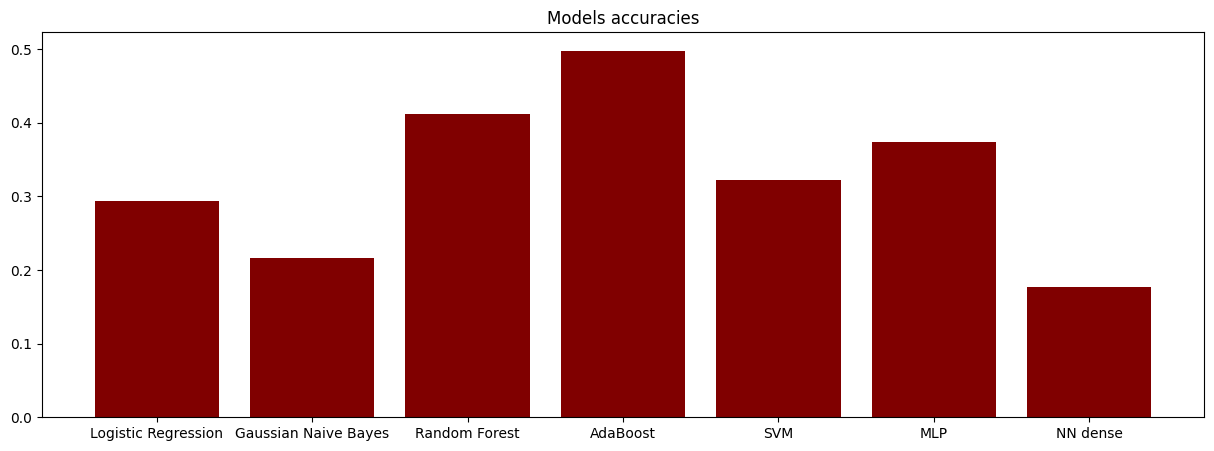

In [662]:
model_results = {
    "Logistic Regression": accuracy_score(y_test_skip_gram, lr_predictions),
    "Gaussian Naive Bayes": accuracy_score(y_test_skip_gram, gnb_predictions),
    "Random Forest": accuracy_score(y_test_skip_gram, rf_predictions),
    "AdaBoost": accuracy_score(y_test_skip_gram, adaboost_predictions),
    "SVM": accuracy_score(y_test_skip_gram, svm_predictions),
    "MLP": accuracy_score(y_test_skip_gram, mlp_predictions),
    "NN dense": scores[1]
}
fig = plt.figure(figsize=(15, 5))
plt.bar(model_results.keys(), model_results.values(), color ='maroon')
plt.title("Models accuracies")
#make the plot wider
plt.show()

## Kaggle competition

In [718]:
df_pr = pd.read_csv('pr-test-data.csv')
df_pr_train = pd.read_csv('pr-training-data.csv')
df_pr

,PhraseId,SentenceId,Phrase,ID
0,15061,8545,As exciting as all this exoticism might sound ...,1
1,15062,8545,As exciting as all this exoticism might sound ...,2
2,15063,8545,exciting as all this exoticism might sound to ...,3
3,15064,8545,exciting as all this exoticism might sound to ...,4
4,15065,8545,as all this exoticism might sound to the typic...,5
...,...,...,...,...
1007,16068,8602,struggles of the working class to life,1008
1008,16069,8602,of the working class to life,1009
1009,16070,8602,the working class to life,1010
1010,16071,8602,the working class,1011


In [719]:
X_train_pr = df_pr_train['Phrase'].values
y_training_pr = df_pr_train['Sentiment'].values
X_training_pr_preprocessed, y_training_pr_preprocessed = preprocess_texts_pipeline(X_train_pr, y_training_pr)
vector_size = 128
cbow_model_pr = Word2Vec(X_training_pr_preprocessed, vector_size=vector_size, window=5, min_count=1, workers=4, sg = 1)
X_training_pr_vectorized, y_training_pr_vectorized = transform_word2vec(cbow_model_pr, X_training_pr_preprocessed, y_training_pr_preprocessed)

100%|██████████| 155048/155048 [00:33<00:00, 4600.19it/s]


In [720]:
X_pr = df_pr['Phrase'].values
y_pr = np.zeros(X_pr.shape)
X_pr_preprocessed, y_pr_preprocessed = preprocess_texts_pipeline(X_pr, y_pr)
cbow_model_pr.build_vocab(X_pr_preprocessed, update=True)
X_pr_vectorized, y_pr_vectorized = transform_word2vec(cbow_model_pr, X_pr_preprocessed, y_pr_preprocessed)
X_pr_vectorized.shape

100%|██████████| 1012/1012 [00:00<00:00, 4251.58it/s]


(1012, 128)

In [721]:
from sklearn.model_selection import GridSearchCV
adaboost_params_pr = {
    'n_estimators': [50, 100, 150, 200],
    'learning_rate': np.logspace(-1, 1, 3),
}
adaboost_model_pr_clf = AdaBoostClassifier()
adaboost_model_pr = GridSearchCV(adaboost_model_pr_clf, adaboost_params_pr, cv=5)
adaboost_model_pr_clf.fit(X_training_pr_vectorized, y_training_pr_vectorized)

AdaBoostClassifier()

In [722]:
pr_predictions = adaboost_model_pr_clf.predict(X_pr_vectorized)
pr_data = {
    "Sentiment": pr_predictions,
    "ID": np.arange(1, len(pr_predictions) + 1)
}
pr_df_submit = pd.DataFrame(pr_data)
pr_df_submit

,Sentiment,ID
0,1,1
1,1,2
2,2,3
3,1,4
4,1,5
...,...,...
1007,2,1008
1008,2,1009
1009,2,1010
1010,2,1011


In [724]:
adaboost_model_pr.fit(X_training_pr_vectorized, y_training_pr_vectorized)
pr_predictions_cv = adaboost_model_pr.predict(X_pr_vectorized)
pr_data_cv = {
    "Sentiment": pr_predictions_cv,
    "ID": np.arange(1, len(pr_predictions) + 1)
}
pr_df_submit_cv = pd.DataFrame(pr_data_cv)
pr_df_submit_cv

In [723]:
pr_df_submit.to_csv('pr-submit.csv', index=False)

In [ ]:
pr_df_submit_cv.to_csv('pr-submit_cv.csv', index=False)